In [1]:
# Oscar Winner Prediction Analysis
# Random Forest Classifier, Probit Model, Logistic Regression, CatBoost, and XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


# 1. Data Loading and Exploration

Loading the merged dataset with Oscar nominees and winners from multiple sources (Wikipedia, IMDB, Letterboxd).


In [2]:
# Load the dataset
df = pd.read_csv('/workspaces/DataDriveOscarProject/DataAnalysis/merged_df_final.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (612, 29)

Columns: ['Year of Film Release', 'Film_wiki', 'Film Studio/Producer(s)', 'is_winner', 'clean_name', 'year', 'Film_imdb', 'url_tried', 'rating', 'keywords', 'stars', 'user_reviews', 'critic_reviews', 'metascore', 'cast_number', 'longitud', 'imdb_url', 'url_used', 'found', 'found_in_imdb', 'description', 'rating_letterboxd', 'number_of_lists', 'number_of_watches', 'number_of_likes', 'number_of_fans', 'name_of_director', 'film_name', 'found_in_letterboxd']

First few rows:


,Year of Film Release,Film_wiki,Film Studio/Producer(s),is_winner,clean_name,year,Film_imdb,url_tried,rating,keywords,...,found_in_imdb,description,rating_letterboxd,number_of_lists,number_of_watches,number_of_likes,number_of_fans,name_of_director,film_name,found_in_letterboxd
0,1927/28 (1st),Wings,"Famous Players–Lasky (Lucien Hubbard, Jesse L....",True,wings-1927,1927.0,Wings,https://letterboxd.com/film/wings-1927,7.5,"['Coming-of-Age', 'War Epic', 'Action', 'Drama...",...,True,"YOUTH, HITTING THE CLOUDS! LAUGHING AT DANGER!...",3.8,28K,29K,7K,87 FANS,William A. Wellman,wings-1927,True
1,1927/28 (1st),7th Heaven,"Fox (William Fox, producer)",False,7th-heaven-1927,1927.0,7th Heaven,https://letterboxd.com/film/7th-heaven-1927,7.5,"['Drama', 'Romance']",...,True,"In 1910s Paris, a sewer worker disillusioned w...",3.7,12K,8.2K,2K,41 FANS,Frank Borzage,7th-heaven-1927,True
2,1927/28 (1st),The Racket,"The Caddo Company (Howard Hughes, producer)",False,the-racket-1927,1928.0,The Racket,https://letterboxd.com/film/the-racket-1927,6.6,"['Film Noir', 'Crime', 'Drama']",...,True,A renegade police captain sets out to catch a ...,3.1,4.2K,2.6K,318,2 FANS,Lewis Milestone,the-racket-1927,True
3,1928/29 (2nd) [a],The Broadway Melody,Metro-Goldwyn-Mayer (Irving Thalberg & Lawrenc...,True,the-broadway-melody-1928,1929.0,The Broadway Melody,https://letterboxd.com/film/the-broadway-melod...,5.5,"['Classic Musical', 'Showbiz Drama', 'Drama', ...",...,True,ALL TALKING. ALL SINGING. ALL DANCING.\nThe va...,2.4,17K,13K,730,2 FANS,Harry Beaumont,the-broadway-melody-1928,True
4,1928/29 (2nd) [a],Alibi,"Feature Productions (Roland West, producer)",False,alibi-1928,1931.0,Alibi,https://letterboxd.com/film/alibi-1928,7.4,['Mystery'],...,True,Belgian sleuth Hercule Poirot investigates a m...,NaN,161,23,1,NaN,Leslie S. Hiscott,alibi-1928,True


In [3]:
df['number_of_lists'] = df['number_of_lists'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_lists'] = df['number_of_lists'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)


df['number_of_watches'] = df['number_of_watches'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_watches'] = df['number_of_watches'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)

df['number_of_likes'] = df['number_of_likes'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_likes'] = df['number_of_likes'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)

df['user_reviews'] = df['user_reviews'].apply(lambda x: str(float(str(x).replace('K', '')) * 1000) if 'K' in str(x) else x)
df['user_reviews'] = df['user_reviews'].apply(lambda x: str(float(str(x).replace('M', '')) * 1000000) if 'M' in str(x) else x)

df['critic_reviews'] = df['critic_reviews'].apply(lambda x: str(float(str(x).replace('K', '')) * 1000) if 'K' in str(x) else x)
df['critic_reviews'] = df['critic_reviews'].apply(lambda x: str(float(str(x).replace('M', '')) * 1000000) if 'M' in str(x) else x)

df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(x).replace(" FANS", ""))
df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(x).replace(" FAN", ""))
df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(float(x.replace('K', '')) * 1000) if 'K' in x else x)
df['number_of_fans'] = df['number_of_fans'].apply(lambda x: str(float(x.replace('M', '')) * 1000000) if 'M' in x else x)


In [4]:
# Clean up the numeric columns: replace NaN with 0 and convert to float
df['number_of_lists'] = pd.to_numeric(df['number_of_lists'], errors='coerce').fillna(0)
df['number_of_watches'] = pd.to_numeric(df['number_of_watches'], errors='coerce').fillna(0)
df['number_of_likes'] = pd.to_numeric(df['number_of_likes'], errors='coerce').fillna(0)
df['number_of_fans'] = pd.to_numeric(df['number_of_fans'], errors='coerce').fillna(0)
df['user_reviews'] = pd.to_numeric(df['user_reviews'], errors='coerce').fillna(0)
df['critic_reviews'] = pd.to_numeric(df['critic_reviews'], errors='coerce').fillna(0)


In [5]:
# Basic statistics about the dataset
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)
print("\nTarget Variable Distribution:")
print(df['is_winner'].value_counts())
print(f"\nPercentage of winners: {df['is_winner'].sum() / len(df) * 100:.2f}%")
print("\n" + "="*50)
print("\nMissing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))


Data Types:
Year of Film Release        object
Film_wiki                   object
Film Studio/Producer(s)     object
is_winner                     bool
clean_name                  object
year                       float64
Film_imdb                   object
url_tried                   object
rating                     float64
keywords                    object
stars                       object
user_reviews               float64
critic_reviews             float64
metascore                  float64
cast_number                float64
longitud                    object
imdb_url                    object
url_used                    object
found                       object
found_in_imdb                 bool
description                 object
rating_letterboxd          float64
number_of_lists            float64
number_of_watches          float64
number_of_likes            float64
number_of_fans             float64
name_of_director            object
film_name                   object
found_in

In [6]:
# Create a working copy
df_work = df.copy()

# Convert target to binary (1 for winner, 0 for nominee)
df_work['is_winner'] = df_work['is_winner'].astype(int)


In [7]:
# Create new features based on director nomination history
print("Creating director nomination history features...")

# Initialize new columns
df_work['director_nominated_before'] = 0
df_work['director_num_previous_nominations'] = 0

# Get unique years in chronological order
unique_years = sorted(df_work['year'].unique())

# For each year, check director history in previous years
for current_year in unique_years:
    # Get indices for current year
    current_year_mask = df_work['year'] == current_year
    current_year_indices = df_work[current_year_mask].index
    
    # Get all previous years
    previous_years = [y for y in unique_years if y < current_year]
    
    # For each film in current year
    for idx in current_year_indices:
        director = df_work.loc[idx, 'name_of_director']
        
        # Count nominations in previous years
        previous_nominations = df_work[
            (df_work['year'].isin(previous_years)) & 
            (df_work['name_of_director'] == director)
        ].shape[0]
        
        # Set the features
        df_work.loc[idx, 'director_nominated_before'] = 1 if previous_nominations > 0 else 0
        df_work.loc[idx, 'director_num_previous_nominations'] = previous_nominations

print("Director nomination history features created!")
print(f"\nDirector feature statistics:")
print(f"Films with director previously nominated: {(df_work['director_nominated_before'] == 1).sum()}")
print(f"Average previous nominations per director: {df_work['director_num_previous_nominations'].mean():.2f}")
print(f"Max previous nominations: {df_work['director_num_previous_nominations'].max()}")
print(df_work[df_work['director_num_previous_nominations'] == df_work['director_num_previous_nominations'].max() - 1])


Creating director nomination history features...


Director nomination history features created!

Director feature statistics:
Films with director previously nominated: 276
Average previous nominations per director: 1.09
Max previous nominations: 12
    Year of Film Release        Film_wiki  \
215          1959 (32nd)          Ben-Hur   
581          2021 (94th)  West Side Story   

                          Film Studio/Producer(s)  is_winner  \
215                                 Sam Zimbalist          1   
581  Steven Spielberg and Kristie Macosko Krieger          0   

               clean_name    year        Film_imdb  \
215          ben-hur-1959  1959.0          Ben-Hur   
581  west-side-story-2021  2021.0  West Side Story   

                                            url_tried  rating  \
215          https://letterboxd.com/film/ben-hur-1959     8.1   
581  https://letterboxd.com/film/west-side-story-2021     7.1   

                                              keywords  ... rating_letterboxd  \
215  ['Adventure Epic', 'Epic', 

In [8]:
# Select numerical features from IMDB
numerical_features = [
    'rating',              # IMDB rating
    'user_reviews',        # Number of user reviews
    'critic_reviews',      # Number of critic reviews
    'metascore',          # Metascore
    'cast_number',        # Number of cast members
    'rating_letterboxd',  # Letterboxd rating
    'number_of_lists',    # Number of Letterboxd lists
    'number_of_watches',  # Number of Letterboxd watches
    'number_of_likes',     # Number of Letterboxd likes
    'director_nominated_before', # Director previously nominated
    'director_num_previous_nominations' # Number of previous nominations
]
available_features = [f for f in numerical_features if f in df_work.columns]
# Check which features exist in the dataset
print(f"Available numerical features: {available_features}")
print(f"\nFeature statistics before imputation:")
print(df_work[available_features].describe())

Available numerical features: ['rating', 'user_reviews', 'critic_reviews', 'metascore', 'cast_number', 'rating_letterboxd', 'number_of_lists', 'number_of_watches', 'number_of_likes', 'director_nominated_before', 'director_num_previous_nominations']

Feature statistics before imputation:
           rating  user_reviews  critic_reviews   metascore  cast_number  \
count  610.000000    612.000000      612.000000  481.000000   611.000000   
mean     7.518197    689.155229      170.055556   80.091476    63.309329   
std      0.594015   1107.178425      172.891516   11.261658    28.395120   
min      4.900000      0.000000        0.000000   34.000000     6.000000   
25%      7.200000    108.500000       43.750000   73.000000    39.000000   
50%      7.500000    311.500000       96.000000   82.000000    62.000000   
75%      7.900000    828.250000      253.750000   88.000000    97.500000   
max      9.300000  11600.000000     1000.000000  100.000000   100.000000   

       rating_letterboxd  n

In [9]:
print("Data cleaning completed!")
print(f"\nMissing values in features:")
for feat in available_features:
    missing_count = df_work[feat].isnull().sum()
    missing_pct = (missing_count / len(df_work)) * 100
    print(f"{feat}: {missing_count} ({missing_pct:.1f}%)")


Data cleaning completed!

Missing values in features:
rating: 2 (0.3%)
user_reviews: 0 (0.0%)
critic_reviews: 0 (0.0%)
metascore: 131 (21.4%)
cast_number: 1 (0.2%)
rating_letterboxd: 27 (4.4%)
number_of_lists: 0 (0.0%)
number_of_watches: 0 (0.0%)
number_of_likes: 0 (0.0%)
director_nominated_before: 0 (0.0%)
director_num_previous_nominations: 0 (0.0%)


In [10]:
# Apply mean imputation for missing values
imputer = SimpleImputer(strategy='mean')

# Create a copy of features for imputation
df_work_features = df_work[available_features].copy()

# Impute missing values
df_work[available_features] = imputer.fit_transform(df_work_features)

print("Mean imputation completed!")
print(f"\nFeature means used for imputation:")
for i, feat in enumerate(available_features):
    print(f"{feat}: {imputer.statistics_[i]:.2f}")

print(f"\nMissing values after imputation:")
print(df_work[available_features].isnull().sum().sum())


Mean imputation completed!

Feature means used for imputation:
rating: 7.52
user_reviews: 689.16
critic_reviews: 170.06
metascore: 80.09
cast_number: 63.31
rating_letterboxd: 3.76
number_of_lists: 95274.12
number_of_watches: 608123.75
number_of_likes: 195841.82
director_nominated_before: 0.45
director_num_previous_nominations: 1.09

Missing values after imputation:
0


In [11]:
# Prepare final dataset for modeling
# Sort by year to ensure chronological order
df_work = df_work[df_work['year'] > 1946]
df_work = df_work.sort_values('year').reset_index(drop=True)

# Create feature matrix X and target y
X = df_work[available_features]
y = df_work['is_winner']
years = df_work['year']
films = df_work['Film_wiki']

print(f"Final dataset shape: {X.shape}")
print(f"Features used: {available_features}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Year range: {df_work['year'].min()} to {df_work['year'].max()}")


Final dataset shape: (458, 11)
Features used: ['rating', 'user_reviews', 'critic_reviews', 'metascore', 'cast_number', 'rating_letterboxd', 'number_of_lists', 'number_of_watches', 'number_of_likes', 'director_nominated_before', 'director_num_previous_nominations']
Target distribution: {0: 380, 1: 78}
Year range: 1947.0 to 2024.0


# 3. Logistic Regression - Cumulative Training Approach

We'll use Logistic Regression with the same cumulative training approach for comparison.


In [12]:
# Function to perform cumulative training and prediction with Logistic Regression
def cumulative_predict_logistic(X, y, years, films, min_train_years=20):
    """
    Train Logistic Regression models cumulatively for each year
    
    Parameters:
    - X: feature matrix
    - y: target variable
    - years: year labels
    - films: film names
    - min_train_years: minimum number of years needed for training
    
    Returns:
    - results dataframe with predictions
    """
    results = []
    unique_years = sorted(years.unique())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    for i, test_year in enumerate(unique_years):
        # Skip if not enough training data
        if i < min_train_years:
            continue
        
        # Split data: train on all previous years, test on current year
        train_mask = years < test_year
        test_mask = years == test_year
        
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            continue
        
        X_train, y_train = X_scaled[train_mask], y[train_mask]
        X_test, y_test = X_scaled[test_mask], y[test_mask]
        
        # Train Logistic Regression model
        logistic_model = LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        )
        
        logistic_model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
        
        # Predict winner (film with highest probability)
        predicted_winner_idx = y_pred_proba.argmax()
        
        # Store results for each nominee in this year
        for j, (film_name, actual_winner, pred_prob) in enumerate(zip(
            films[test_mask], y_test, y_pred_proba)):
            
            results.append({
                'Year': test_year,
                'Film': film_name,
                'Actual_Winner': actual_winner,
                'Logistic_Probability': pred_prob,
                'Logistic_Predicted_Winner': (j == predicted_winner_idx),
                'Training_Size': train_mask.sum()
            })
    
    return pd.DataFrame(results)

print("Logistic Regression cumulative prediction function defined.")
print("Starting cumulative training and prediction...")


Logistic Regression cumulative prediction function defined.
Starting cumulative training and prediction...


In [13]:
# Run Logistic Regression cumulative prediction
logistic_results = cumulative_predict_logistic(X, y, years, films, min_train_years=20)

print(f"Logistic Regression predictions completed for {logistic_results['Year'].nunique()} years")
print(f"\nSample predictions:")
print(logistic_results.tail(20))

true_positive_predictions = logistic_results[(logistic_results['Actual_Winner'] == 1) & (logistic_results['Logistic_Predicted_Winner'] == True)]

print(f"\nActual winners and Predicted winners: ")
print(true_positive_predictions.tail(20))

# Calculate year-by-year accuracy
logistic_yearly_accuracy = []
for year in logistic_results['Year'].unique():
    year_data = logistic_results[logistic_results['Year'] == year]
    predicted_winner = year_data[year_data['Logistic_Predicted_Winner'] == True]
    actual_winner = year_data[year_data['Actual_Winner'] == 1]
    
    if len(predicted_winner) > 0 and len(actual_winner) > 0:
        correct = predicted_winner['Film'].values[0] == actual_winner['Film'].values[0]
        logistic_yearly_accuracy.append(correct)

logistic_overall_accuracy = np.mean(logistic_yearly_accuracy) if logistic_yearly_accuracy else 0
print(f"\nLogistic Regression Overall Accuracy: {logistic_overall_accuracy:.2%}")


Logistic Regression predictions completed for 58 years

Sample predictions:
       Year                        Film  Actual_Winner  Logistic_Probability  \
337  2023.0        The Zone of Interest              0              0.727362   
338  2023.0                 Poor Things              0              0.616072   
339  2023.0                  Past Lives              0              0.583125   
340  2023.0                     Maestro              0              0.443571   
341  2023.0  Killers of the Flower Moon              0              0.550866   
342  2023.0               The Holdovers              0              0.599090   
343  2023.0           Anatomy of a Fall              0              0.641433   
344  2023.0            American Fiction              0              0.628964   
345  2023.0                 Oppenheimer              1              0.782106   
346  2023.0                      Barbie              0              0.067755   
347  2024.0                Emilia Pérez     

In [14]:
last_5_years_predictions = logistic_results[logistic_results['Year'] >= 2020]

In [15]:
# Normalize probabilities so they sum to 1 for each year
last_5_years_predictions = last_5_years_predictions.copy()
last_5_years_predictions['Logistic_Probability'] = last_5_years_predictions.groupby('Year')['Logistic_Probability'].transform(lambda x: x / x.sum())


In [16]:
last_5_years_predictions.tail(20)

,Year,Film,Actual_Winner,Logistic_Probability,Logistic_Predicted_Winner,Training_Size
337,2023.0,The Zone of Interest,0,0.128957,False,438
338,2023.0,Poor Things,0,0.109226,False,438
339,2023.0,Past Lives,0,0.103385,False,438
340,2023.0,Maestro,0,0.078642,False,438
341,2023.0,Killers of the Flower Moon,0,0.097665,False,438
342,2023.0,The Holdovers,0,0.106215,False,438
343,2023.0,Anatomy of a Fall,0,0.113722,False,438
344,2023.0,American Fiction,0,0.111512,False,438
345,2023.0,Oppenheimer,1,0.138663,True,438
346,2023.0,Barbie,0,0.012013,False,438


In [17]:
last_5_years_predictions['fair_odds'] = 1 / last_5_years_predictions['Logistic_Probability']
last_5_years_predictions['odds_10_overrounded'] = last_5_years_predictions['fair_odds']/(1+0.1)
last_5_years_predictions['odds_15_overrounded'] = last_5_years_predictions['fair_odds']/(1+0.15)
last_5_years_predictions['odds_20_overrounded'] = last_5_years_predictions['fair_odds']/(1+0.2)
last_5_years_predictions

,Year,Film,Actual_Winner,Logistic_Probability,Logistic_Predicted_Winner,Training_Size,fair_odds,odds_10_overrounded,odds_15_overrounded,odds_20_overrounded
310,2020.0,Nomadland,1,0.227612,True,411,4.393436,3.994033,3.820379,3.661197
311,2020.0,The Father,0,0.183470,False,411,5.450491,4.954992,4.739558,4.542076
312,2020.0,Mank,0,0.144525,False,411,6.919223,6.290203,6.016716,5.766019
313,2020.0,Minari,0,0.161001,False,411,6.211137,5.646488,5.400989,5.175947
314,2020.0,Promising Young Woman,0,0.103640,False,411,9.648739,8.771581,8.390208,8.040616
315,2020.0,The Trial of the Chicago 7,0,0.179752,False,411,5.563235,5.057487,4.837596,4.636029
316,2021.0,King Richard,0,0.116670,False,417,8.571176,7.791978,7.453197,7.142647
317,2021.0,The Power of the Dog,0,0.085221,False,417,11.734222,10.667475,10.203672,9.778519
318,2021.0,Nightmare Alley,0,0.071591,False,417,13.968147,12.698315,12.146214,11.640122
319,2021.0,West Side Story,0,0.064999,False,417,15.384800,13.986182,13.378087,12.820667


## Set the bettors probability of betting to each of the movies

In [18]:
import pandas as pd
import numpy as np

# Crear columna de proporción de apuestas basada en los fair_odds
def calculate_betting_proportions(df):
    """
    Calcula la proporción de apuestas para cada película dentro de su año
    basado en los fair_odds del mercado.

    """
    df = df.copy()
    
    # Calcular probabilidad implícita de cada película
    df['implied_probability'] = 1 / df['fair_odds']
    
    
    return df

# Aplicar la función
last_5_years_predictions = calculate_betting_proportions(last_5_years_predictions)

# Ver resultado
print(last_5_years_predictions[['Year', 'Film', 'fair_odds', 'implied_probability']])

       Year                               Film  fair_odds  implied_probability
310  2020.0                          Nomadland   4.393436             0.227612
311  2020.0                         The Father   5.450491             0.183470
312  2020.0                               Mank   6.919223             0.144525
313  2020.0                             Minari   6.211137             0.161001
314  2020.0              Promising Young Woman   9.648739             0.103640
315  2020.0         The Trial of the Chicago 7   5.563235             0.179752
316  2021.0                       King Richard   8.571176             0.116670
317  2021.0               The Power of the Dog  11.734222             0.085221
318  2021.0                    Nightmare Alley  13.968147             0.071591
319  2021.0                    West Side Story  15.384800             0.064999
320  2021.0                               Dune  15.516892             0.064446
321  2021.0                     Licorice Pizza   7.3

## heterogeneity of beliefs (tukey lambda distribution)

In [19]:
from scipy import stats

def add_belief_heterogeneity(df, lambda_param=0.14, noise_scale=0.05, n_bettors=1000):
    """
    Agrega heterogeneidad de creencias usando Tukey-Lambda distribution.
    Ahora simula un pool de apostadores por año que distribuyen sus apuestas.
    
    Parameters:
    - lambda_param: parámetro de forma de Tukey-Lambda (0.14 ≈ normal)
    - noise_scale: escala del ruido a agregar
    - n_bettors: número de apostadores simulados por año
    """
    df = df.copy()
    
    # Primero calcular la proporción base
    df = calculate_betting_proportions(df)
    
    np.random.seed(42)
    
    # Listas para almacenar resultados
    belief_means = []
    belief_stds = []
    prop_active_bettors = []
    
    # Procesar por año
    for year in df['Year'].unique():
        year_mask = df['Year'] == year
        year_films = df[year_mask].copy()
        n_films = len(year_films)
        
        # Generar creencias de apostadores para TODAS las películas del año
        # Cada fila = un apostador, cada columna = una película
        beliefs_matrix = np.zeros((n_bettors, n_films))
        
        for film_idx, (idx, row) in enumerate(year_films.iterrows()):
            center = row['implied_probability']
            
            # Generar distribución de creencias usando Tukey-Lambda
            tukey_samples = stats.tukeylambda.rvs(lambda_param, size=n_bettors)
            beliefs = center + noise_scale * tukey_samples
            beliefs = np.clip(beliefs, 0, 1)
            
            beliefs_matrix[:, film_idx] = beliefs
        
        # Cada apostador apuesta a la película con mayor creencia esperada ajustada por odds
        # Un apostador apuesta si: belief_i / odds_i > umbral
        implied_probs = year_films['implied_probability'].values
        
        # Calcular retorno esperado para cada apostador en cada película
        # expected_return = belief * odds - 1
        odds_array = year_films['fair_odds'].values
        expected_returns = beliefs_matrix * odds_array - 1
        
        # Cada apostador elige la película con mayor retorno esperado (si es positivo)
        best_choices = np.argmax(expected_returns, axis=1)
        has_positive_return = np.max(expected_returns, axis=1) > 0
        
        # Contar apuestas por película
        bets_per_film = np.zeros(n_films)
        for bettor_idx in range(n_bettors):
            if has_positive_return[bettor_idx]:
                chosen_film = best_choices[bettor_idx]
                bets_per_film[chosen_film] += 1
        
        # Normalizar para obtener proporciones (solo entre los que apuestan)
        total_active_bettors = bets_per_film.sum()
        if total_active_bettors > 0:
            film_proportions = bets_per_film / total_active_bettors
        else:
            film_proportions = np.zeros(n_films)
        
        # Agregar resultados para cada película del año
        for film_idx, (idx, row) in enumerate(year_films.iterrows()):
            belief_means.append(beliefs_matrix[:, film_idx].mean())
            belief_stds.append(beliefs_matrix[:, film_idx].std())
            prop_active_bettors.append(film_proportions[film_idx])
    
    # Agregar columnas al dataframe
    df['belief_mean'] = belief_means
    df['belief_std'] = belief_stds
    df['prop_active_bettors'] = prop_active_bettors
    
    return df

# Aplicar con heterogeneidad
last_5_years_predictions = add_belief_heterogeneity(
    last_5_years_predictions, 
    lambda_param=0.14,  # ≈ normal distribution
    noise_scale=0.05,
    n_bettors=1000
)

# Verificar que ahora suma 1 por año
print("Suma de prop_active_bettors por año:")
print(last_5_years_predictions.groupby('Year')['prop_active_bettors'].sum())

# Ver distribución
print("\nPrimeras filas:")
print(last_5_years_predictions[['Year', 'Film', 'fair_odds', 'implied_probability', 
                                 'prop_active_bettors', 'belief_mean']].tail(15))

Suma de prop_active_bettors por año:
Year
2020.0    1.0
2021.0    1.0
2022.0    1.0
2023.0    1.0
2024.0    1.0
Name: prop_active_bettors, dtype: float64

Primeras filas:
       Year                Film  fair_odds  implied_probability  \
342  2023.0       The Holdovers   9.414856             0.106215   
343  2023.0   Anatomy of a Fall   8.793344             0.113722   
344  2023.0    American Fiction   8.967681             0.111512   
345  2023.0         Oppenheimer   7.211738             0.138663   
346  2023.0              Barbie  83.246221             0.012013   
347  2024.0        Emilia Pérez   9.605707             0.104105   
348  2024.0         Nickel Boys  10.383709             0.096305   
349  2024.0      I'm Still Here   8.437894             0.118513   
350  2024.0      Dune: Part Two   8.080419             0.123756   
351  2024.0       The Substance   7.899593             0.126589   
352  2024.0  A Complete Unknown  11.110019             0.090009   
353  2024.0       The Bru

# Betting House Revenue Analysis

Now we'll calculate the expected revenue for a betting house using our model predictions across three overround scenarios (10%, 15%, 20%).


In [20]:
def calculate_betting_house_revenue(df, overround, total_bettors, bet_amount=10):
    """
    Calculate betting house revenue for a given overround scenario.
    
    Parameters:
    - df: DataFrame with predictions and betting proportions
    - overround: overround percentage (e.g., 0.10 for 10%)
    - total_bettors: total number of bettors
    - bet_amount: amount each bettor bets (default $10)
    
    Returns:
    - Dictionary with revenue breakdown by year and totals
    """
    results = []
    
    # Get the appropriate odds column
    if overround == 0.10:
        odds_col = 'odds_10_overrounded'
    elif overround == 0.15:
        odds_col = 'odds_15_overrounded'
    elif overround == 0.20:
        odds_col = 'odds_20_overrounded'
    else:
        raise ValueError("Overround must be 0.10, 0.15, or 0.20")
    
    # Calculate revenue for each year
    for year in sorted(df['Year'].unique()):
        year_data = df[df['Year'] == year].copy()
        
        # Total stakes collected from all bettors
        total_stakes = total_bettors * bet_amount
        
        # Calculate bets placed on each film
        year_data['num_bettors'] = year_data['prop_active_bettors'] * total_bettors
        year_data['stakes_on_film'] = year_data['num_bettors'] * bet_amount
        
        # Find the actual winner
        winner_mask = year_data['Actual_Winner'] == 1

        winner_data = year_data[winner_mask].iloc[0]
        
        # los que le apostaron al ganador les tengo que pagar lo que les prometi en odds_col
        payout = winner_data['stakes_on_film'] * winner_data[odds_col]
        
        # Revenue = Stakes collected - Payouts
        revenue = total_stakes - payout
        profit_margin = (revenue / total_stakes) * 100
        
        results.append({
            'Year': int(year),
            'Total_Stakes': total_stakes,
            'Winner': winner_data['Film'],
            'Winner_Stakes': winner_data['stakes_on_film'],
            'Winner_Odds': winner_data[odds_col],
            'Payout': payout,
            'Revenue': revenue,
            'Profit_Margin_Pct': profit_margin
        })
    
    return pd.DataFrame(results)


## Actual Revenue Analysis

Calculate the actual revenue the betting house would have earned based on real Oscar winners.


In [21]:

# Calculate actual revenue for each overround scenario
## esto es asumiendo una elasticidad de -0.7
overround_scenarios = [
    (0.10, 1000, "10% Overround"),
    (0.15, 965, "15% Overround"),
    (0.20, 931, "20% Overround")
]

actual_revenue_results = {}

for overround, bettors, label in overround_scenarios:
    revenue_df = calculate_betting_house_revenue(
        last_5_years_predictions, 
        overround=overround, 
        total_bettors=bettors,
        bet_amount=10
    )
    actual_revenue_results[label] = revenue_df
    
    print(f"\n{'='*80}")
    print(f"{label} - {bettors} bettors @ $10 each")
    print(f"{'='*80}")
    print(revenue_df.to_string(index=False))
    print(f"\nTOTAL REVENUE: ${revenue_df['Revenue'].sum():,.2f}")
    print(f"AVERAGE REVENUE PER YEAR: ${revenue_df['Revenue'].mean():,.2f}")
    print(f"AVERAGE PROFIT MARGIN: {revenue_df['Profit_Margin_Pct'].mean():.2f}%")
    print(f"TOTAL STAKES COLLECTED: ${revenue_df['Total_Stakes'].sum():,.2f}")
    print(f"TOTAL PAYOUTS: ${revenue_df['Payout'].sum():,.2f}")



10% Overround - 1000 bettors @ $10 each
 Year  Total_Stakes                            Winner  Winner_Stakes  Winner_Odds      Payout     Revenue  Profit_Margin_Pct
 2020         10000                         Nomadland    1007.121058     3.994033 4022.474577 5977.525423          59.775254
 2021         10000                              CODA     400.000000     7.529473 3011.789216 6988.210784          69.882108
 2022         10000 Everything Everywhere All at Once     470.000000     7.791799 3662.145641 6337.854359          63.378544
 2023         10000                       Oppenheimer     370.741483     6.556126 2430.627839 7569.372161          75.693722
 2024         10000                             Anora     350.701403     6.794391 2382.802325 7617.197675          76.171977

TOTAL REVENUE: $34,490.16
AVERAGE REVENUE PER YEAR: $6,898.03
AVERAGE PROFIT MARGIN: 68.98%
TOTAL STAKES COLLECTED: $50,000.00
TOTAL PAYOUTS: $15,509.84

15% Overround - 965 bettors @ $10 each
 Year  Total_St

## Expected Revenue Analysis

Calculate the expected revenue based on the model's probability predictions (theoretical expected profit).


In [22]:
def calculate_expected_revenue(df, overround, total_bettors, bet_amount=10):
    """
    Calculate expected revenue based on model's probability predictions.
    
    Expected payout for each film = P(win) * stakes_on_film * odds
    Total expected payout = sum over all films
    Expected revenue = Total stakes - Total expected payout
    """
    results = []
    
    # Get the appropriate odds column
    if overround == 0.10:
        odds_col = 'odds_10_overrounded'
    elif overround == 0.15:
        odds_col = 'odds_15_overrounded'
    elif overround == 0.20:
        odds_col = 'odds_20_overrounded'
    else:
        raise ValueError("Overround must be 0.10, 0.15, or 0.20")
    
    # Calculate expected revenue for each year
    for year in sorted(df['Year'].unique()):
        year_data = df[df['Year'] == year].copy()
        
        # Total stakes collected from all bettors
        total_stakes = total_bettors * bet_amount
        
        # Calculate bets placed on each film
        year_data['num_bettors'] = year_data['prop_active_bettors'] * total_bettors
        year_data['stakes_on_film'] = year_data['num_bettors'] * bet_amount
        
        # Calculate expected payout for each film
        # Expected payout = P(film wins) * stakes on film * odds
        year_data['expected_payout'] = (
            year_data['Logistic_Probability'] * 
            year_data['stakes_on_film'] * 
            year_data[odds_col]
        )
        
        # Total expected payout across all films
        total_expected_payout = year_data['expected_payout'].sum()
        
        # Expected revenue
        expected_revenue = total_stakes - total_expected_payout
        profit_margin = (expected_revenue / total_stakes) * 100
        
        results.append({
            'Year': int(year),
            'Total_Stakes': total_stakes,
            'Expected_Payout': total_expected_payout,
            'Expected_Revenue': expected_revenue,
            'Expected_Profit_Margin_Pct': profit_margin
        })
    
    return pd.DataFrame(results)

# Calculate expected revenue for each overround scenario
expected_revenue_results = {}

for overround, bettors, label in overround_scenarios:
    expected_df = calculate_expected_revenue(
        last_5_years_predictions, 
        overround=overround, 
        total_bettors=bettors,
        bet_amount=10
    )
    expected_revenue_results[label] = expected_df
    
    print(f"\n{'='*80}")
    print(f"EXPECTED REVENUE - {label} - {bettors} bettors @ $10 each")
    print(f"{'='*80}")
    print(expected_df.to_string(index=False))
    print(f"\nTOTAL EXPECTED REVENUE: ${expected_df['Expected_Revenue'].sum():,.2f}")
    print(f"AVERAGE EXPECTED REVENUE PER YEAR: ${expected_df['Expected_Revenue'].mean():,.2f}")
    print(f"AVERAGE EXPECTED PROFIT MARGIN: {expected_df['Expected_Profit_Margin_Pct'].mean():.2f}%")



EXPECTED REVENUE - 10% Overround - 1000 bettors @ $10 each
 Year  Total_Stakes  Expected_Payout  Expected_Revenue  Expected_Profit_Margin_Pct
 2020         10000      9090.909091        909.090909                    9.090909
 2021         10000      9090.909091        909.090909                    9.090909
 2022         10000      9090.909091        909.090909                    9.090909
 2023         10000      9090.909091        909.090909                    9.090909
 2024         10000      9090.909091        909.090909                    9.090909

TOTAL EXPECTED REVENUE: $4,545.45
AVERAGE EXPECTED REVENUE PER YEAR: $909.09
AVERAGE EXPECTED PROFIT MARGIN: 9.09%

EXPECTED REVENUE - 15% Overround - 965 bettors @ $10 each
 Year  Total_Stakes  Expected_Payout  Expected_Revenue  Expected_Profit_Margin_Pct
 2020          9650      8391.304348       1258.695652                   13.043478
 2021          9650      8391.304348       1258.695652                   13.043478
 2022          965

## Comparison: Actual vs Expected Revenue

Compare actual revenue (based on real winners) with expected revenue (based on model predictions).



BETTING HOUSE REVENUE COMPARISON - ACTUAL vs EXPECTED
     Scenario  Total_Bettors  Total_Stakes  Actual_Revenue  Expected_Revenue  Revenue_Difference  Actual_Profit_Margin  Expected_Profit_Margin
10% Overround           1000         50000    34490.160402       4545.454545        29944.705857             68.980321                9.090909
15% Overround            965         48250    33933.743710       6293.478261        27640.265449             70.329003               13.043478
20% Overround            931         46550    33313.644390       7758.333333        25555.311056             71.565294               16.666667




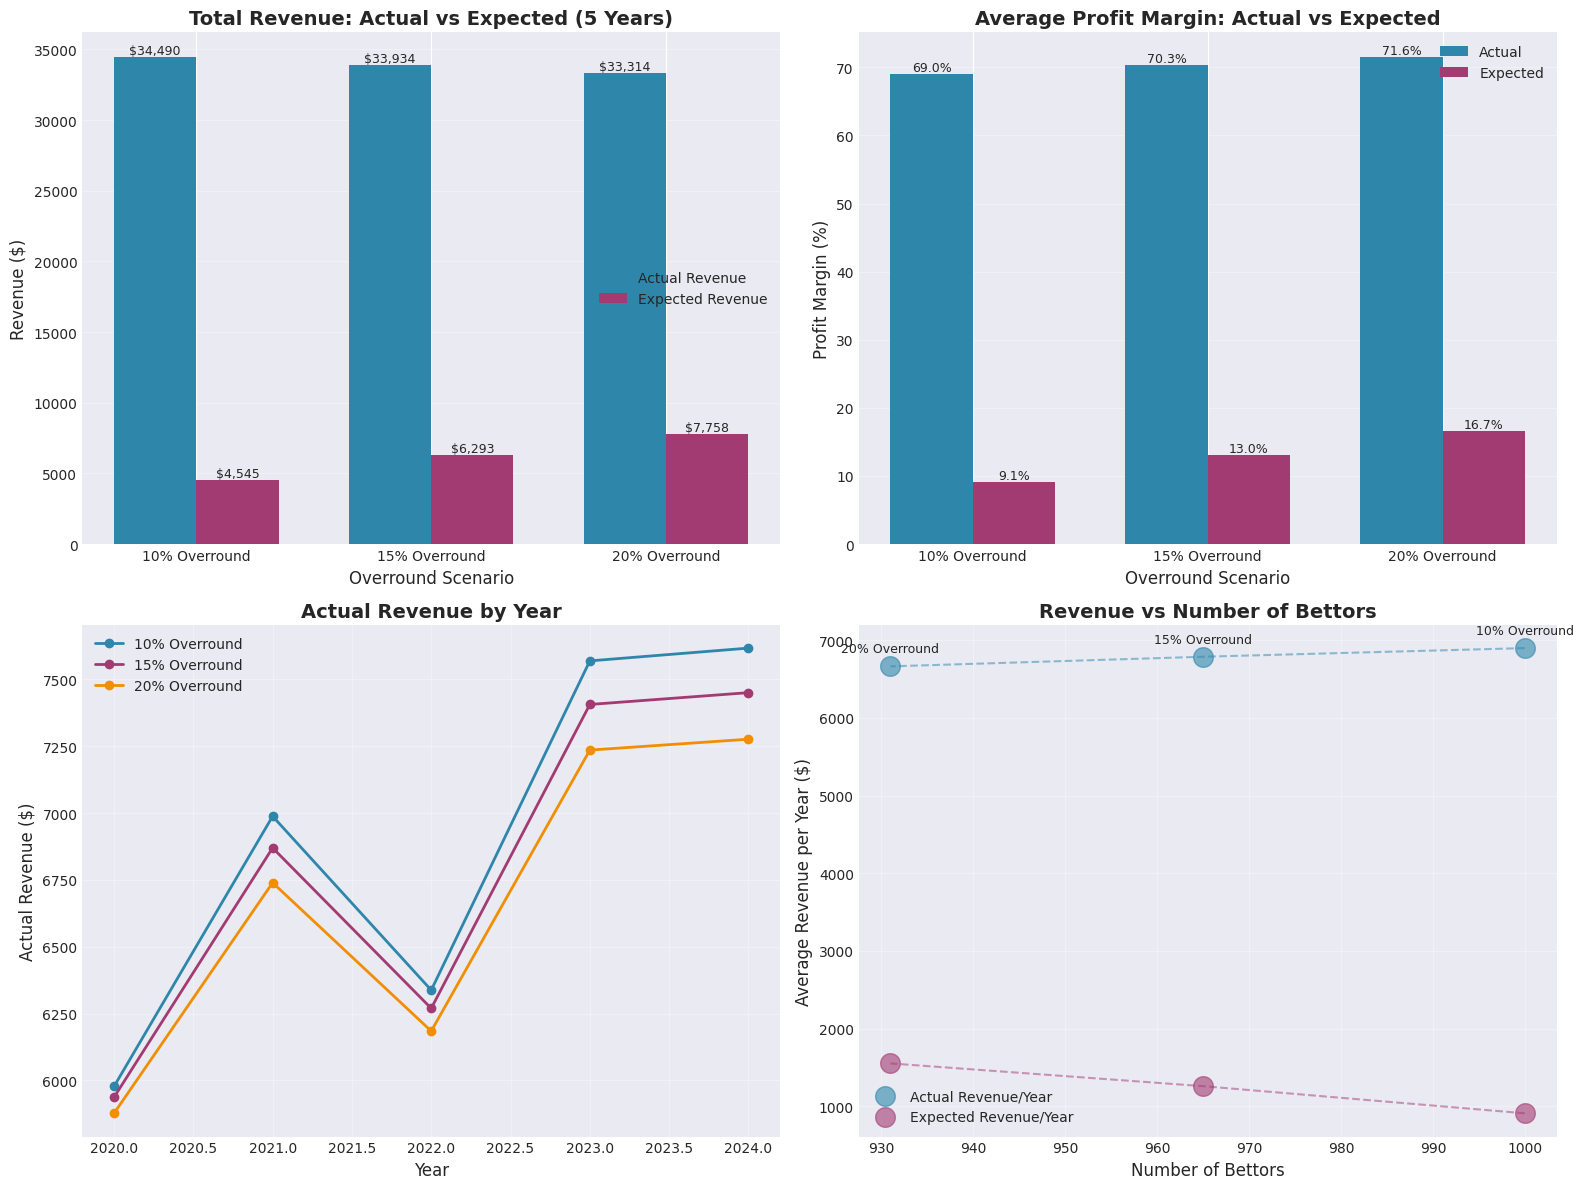


KEY OBSERVATIONS:
----------------------------------------------------------------------------------------------------


In [23]:
# Create comprehensive comparison table
comparison_data = []

for label in ["10% Overround", "15% Overround", "20% Overround"]:
    actual_df = actual_revenue_results[label]
    expected_df = expected_revenue_results[label]
    
    comparison_data.append({
        'Scenario': label,
        'Total_Bettors': 1000 if '10%' in label else (965 if '15%' in label else 931),
        'Total_Stakes': actual_df['Total_Stakes'].sum(),
        'Actual_Revenue': actual_df['Revenue'].sum(),
        'Expected_Revenue': expected_df['Expected_Revenue'].sum(),
        'Revenue_Difference': actual_df['Revenue'].sum() - expected_df['Expected_Revenue'].sum(),
        'Actual_Profit_Margin': actual_df['Profit_Margin_Pct'].mean(),
        'Expected_Profit_Margin': expected_df['Expected_Profit_Margin_Pct'].mean(),
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("BETTING HOUSE REVENUE COMPARISON - ACTUAL vs EXPECTED")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total Revenue Comparison
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.35
bars1 = ax1.bar(x - width/2, comparison_df['Actual_Revenue'], width, label='Actual Revenue', color='#2E86AB')
bars2 = ax1.bar(x + width/2, comparison_df['Expected_Revenue'], width, label='Expected Revenue', color='#A23B72')
ax1.set_xlabel('Overround Scenario', fontsize=12)
ax1.set_ylabel('Revenue ($)', fontsize=12)
ax1.set_title('Total Revenue: Actual vs Expected (5 Years)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Scenario'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom', fontsize=9)

# 2. Profit Margin Comparison
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, comparison_df['Actual_Profit_Margin'], width, label='Actual', color='#2E86AB')
bars4 = ax2.bar(x + width/2, comparison_df['Expected_Profit_Margin'], width, label='Expected', color='#A23B72')
ax2.set_xlabel('Overround Scenario', fontsize=12)
ax2.set_ylabel('Profit Margin (%)', fontsize=12)
ax2.set_title('Average Profit Margin: Actual vs Expected', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Scenario'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

# 3. Revenue by Year for each scenario
ax3 = axes[1, 0]
years = actual_revenue_results["10% Overround"]['Year'].values
for label, color in zip(["10% Overround", "15% Overround", "20% Overround"], 
                        ['#2E86AB', '#A23B72', '#F18F01']):
    revenues = actual_revenue_results[label]['Revenue'].values
    ax3.plot(years, revenues, marker='o', linewidth=2, label=label, color=color)

ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Actual Revenue ($)', fontsize=12)
ax3.set_title('Actual Revenue by Year', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Revenue vs Number of Bettors
ax4 = axes[1, 1]
bettors = comparison_df['Total_Bettors'].values
actual_per_year = comparison_df['Actual_Revenue'] / 5  # 5 years
expected_per_year = comparison_df['Expected_Revenue'] / 5

ax4.scatter(bettors, actual_per_year, s=200, alpha=0.6, label='Actual Revenue/Year', color='#2E86AB')
ax4.scatter(bettors, expected_per_year, s=200, alpha=0.6, label='Expected Revenue/Year', color='#A23B72')
ax4.plot(bettors, actual_per_year, linestyle='--', alpha=0.5, color='#2E86AB')
ax4.plot(bettors, expected_per_year, linestyle='--', alpha=0.5, color='#A23B72')

for i, (b, a, e) in enumerate(zip(bettors, actual_per_year, expected_per_year)):
    ax4.annotate(f'{comparison_df["Scenario"].iloc[i]}', 
                (b, a), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

ax4.set_xlabel('Number of Bettors', fontsize=12)
ax4.set_ylabel('Average Revenue per Year ($)', fontsize=12)
ax4.set_title('Revenue vs Number of Bettors', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY OBSERVATIONS:")
print("-" * 100)


## Key Business Insights

Analyzing which overround strategy maximizes revenue and understanding the revenue dynamics.


In [24]:
# 1. Optimal Overround Strategy
print("1. OPTIMAL OVERROUND STRATEGY")
print("-" * 100)
optimal_idx = comparison_df['Actual_Revenue'].idxmax()
optimal_scenario = comparison_df.iloc[optimal_idx]
print(f"   Maximum Revenue: {optimal_scenario['Scenario']}")
print(f"   Total Revenue: ${optimal_scenario['Actual_Revenue']:,.2f}")
print(f"   Revenue per Year: ${optimal_scenario['Actual_Revenue']/5:,.2f}")
print(f"   Number of Bettors: {int(optimal_scenario['Total_Bettors'])}")
print(f"   Revenue per Bettor per Year: ${optimal_scenario['Actual_Revenue']/(5*optimal_scenario['Total_Bettors']):.2f}")

print("\n2. REVENUE VOLATILITY")
print("-" * 100)
for label in ["10% Overround", "15% Overround", "20% Overround"]:
    revenues = actual_revenue_results[label]['Revenue'].values
    mean_rev = revenues.mean()
    std_rev = revenues.std()
    cv = (std_rev / mean_rev) * 100 if mean_rev != 0 else 0
    print(f"   {label}:")
    print(f"      Mean Revenue per Year: ${mean_rev:,.2f}")
    print(f"      Std Deviation: ${std_rev:,.2f}")
    print(f"      Coefficient of Variation: {cv:.2f}%")
    print(f"      Min: ${revenues.min():,.2f}, Max: ${revenues.max():,.2f}")
    print()

print("3. OVERROUND IMPACT ON REVENUE")
print("-" * 100)
# Calculate revenue from overround vs lucky outcomes
for i, row in comparison_df.iterrows():
    total_stakes = row['Total_Stakes']
    expected_rev = row['Expected_Revenue']
    actual_rev = row['Actual_Revenue']
    
    # Expected revenue comes entirely from overround (house edge)
    overround_revenue_pct = (expected_rev / actual_rev) * 100 if actual_rev != 0 else 0
    lucky_revenue_pct = ((actual_rev - expected_rev) / actual_rev) * 100 if actual_rev != 0 else 0
    
    print(f"   {row['Scenario']}:")
    print(f"      Expected Revenue (from overround): ${expected_rev:,.2f} ({overround_revenue_pct:.1f}%)")
    print(f"      Luck Component: ${actual_rev - expected_rev:,.2f} ({lucky_revenue_pct:.1f}%)")
    print(f"      Total Actual Revenue: ${actual_rev:,.2f}")
    print()

print("4. BETTOR PARTICIPATION IMPACT")
print("-" * 100)
# Calculate revenue efficiency (revenue per bettor lost)
base_bettors = 1000
base_revenue = comparison_df[comparison_df['Scenario'] == '10% Overround']['Actual_Revenue'].values[0]

for i, row in comparison_df.iterrows():
    if row['Scenario'] != '10% Overround':
        bettor_loss = base_bettors - row['Total_Bettors']
        revenue_change = row['Actual_Revenue'] - base_revenue
        efficiency = revenue_change / bettor_loss if bettor_loss != 0 else 0
        
        print(f"   {row['Scenario']} vs 10% Overround:")
        print(f"      Bettors Lost: {int(bettor_loss)}")
        print(f"      Revenue Change: ${revenue_change:,.2f}")
        print(f"      Revenue Change per Bettor Lost: ${efficiency:,.2f}")
        print()

print("5. MODEL PREDICTION ACCURACY IMPACT")
print("-" * 100)
for i, row in comparison_df.iterrows():
    difference = abs(row['Revenue_Difference'])
    accuracy_impact = (difference / row['Actual_Revenue']) * 100 if row['Actual_Revenue'] != 0 else 0
    
    print(f"   {row['Scenario']}:")
    print(f"      Actual Revenue: ${row['Actual_Revenue']:,.2f}")
    print(f"      Expected Revenue: ${row['Expected_Revenue']:,.2f}")
    print(f"      Difference: ${difference:,.2f} ({accuracy_impact:.2f}%)")
    
    if row['Actual_Revenue'] > row['Expected_Revenue']:
        print(f"      Status: House got LUCKY (higher actual revenue)")
    else:
        print(f"      Status: House got UNLUCKY (lower actual revenue)")
    print()

print("6. RECOMMENDATION")
print("-" * 100)
print(f"   Based on 5 years of actual Oscar data:")
print(f"   - OPTIMAL STRATEGY: {optimal_scenario['Scenario']}")
print(f"   - Expected to generate: ${optimal_scenario['Expected_Revenue']/5:,.2f} per year")
print(f"   - Historically generated: ${optimal_scenario['Actual_Revenue']/5:,.2f} per year")
print(f"   - Profit Margin: {optimal_scenario['Actual_Profit_Margin']:.2f}%")
print(f"\n   Trade-off Analysis:")
for i, row in comparison_df.iterrows():
    print(f"   - {row['Scenario']}: {int(row['Total_Bettors'])} bettors → ${row['Actual_Revenue']:,.2f} total revenue")


1. OPTIMAL OVERROUND STRATEGY
----------------------------------------------------------------------------------------------------
   Maximum Revenue: 10% Overround
   Total Revenue: $34,490.16
   Revenue per Year: $6,898.03
   Number of Bettors: 1000
   Revenue per Bettor per Year: $6.90

2. REVENUE VOLATILITY
----------------------------------------------------------------------------------------------------
   10% Overround:
      Mean Revenue per Year: $6,898.03
      Std Deviation: $653.78
      Coefficient of Variation: 9.48%
      Min: $5,977.53, Max: $7,617.20

   15% Overround:
      Mean Revenue per Year: $6,786.75
      Std Deviation: $603.47
      Coefficient of Variation: 8.89%
      Min: $5,937.08, Max: $7,450.57

   20% Overround:
      Mean Revenue per Year: $6,662.73
      Std Deviation: $557.95
      Coefficient of Variation: 8.37%
      Min: $5,877.15, Max: $7,276.48

3. OVERROUND IMPACT ON REVENUE
---------------------------------------------------------------------